<a href="https://colab.research.google.com/github/TarunMadan93/CreditScorecard/blob/master/Credit_scorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1-ViHvO73jWoSS4ZvDJ0Vw6yajTKOMwHM'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train_data.csv')

In [0]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import json
import warnings
warnings.filterwarnings("ignore")

In [0]:
#read data
df = pd.read_csv("train_data.csv")

In [5]:
#explore data
df.drop(columns = 'Unnamed: 0', axis=1, inplace=True)
print(df.shape)
print(list(df.columns))

(150000, 11)
['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [6]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Monthly Income and No of Dependents have missing values

Age, Revolving Utilization require invalid value treatment

In [0]:
#define functions for imputation of missing fields (Numerical & Categorical)

def impute_missing_numnerical(column_name):
  median_value = df[column_name].median()
  df.loc[df[column_name].isnull(), column_name] = median_value

def impute_missing_categorical(column_name):
  mode_value = df[column_name].mode()[0]
  df.loc[df[column_name].isnull(), column_name] = mode_value

In [0]:
#define function to identify invalid values and replace them with legitimate values

def invalid_value_identifier(column_name, min_value, max_value, median_impute=True):
  if np.isnan(min_value) == False:
    if median_impute == True:
      df.loc[df[column_name] < min_value, column_name] = np.nan 
    else:
      df.loc[df[column_name] < min_value, column_name] = min_value   
  if np.isnan(max_value) == False:
    if median_impute == True:
      df.loc[df[column_name] > max_value, column_name] = np.nan
    else:
      df.loc[df[column_name] > max_value, column_name] = max_value

In [0]:
#perform invalid check and remedy on 2 variables

invalid_value_identifier(column_name='age', min_value=21, max_value=100, median_impute=True)
invalid_value_identifier(column_name='RevolvingUtilizationOfUnsecuredLines', min_value=np.nan, max_value=1, median_impute=False)

In [0]:
#perform missing value imputation on 3 columns

impute_missing_numnerical(column_name='age')  
impute_missing_numnerical(column_name='MonthlyIncome')
impute_missing_numnerical(column_name='NumberOfDependents')  

In [11]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,0.319196,52.291073,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,0.249746,0.349481,14.763474,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.000000,99.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [0]:
#define target and predictor variables

target_column = 'SeriousDlqin2yrs'
predictors = list(df.columns)
predictors.remove(target_column)

RevolvingUtilizationOfUnsecuredLines


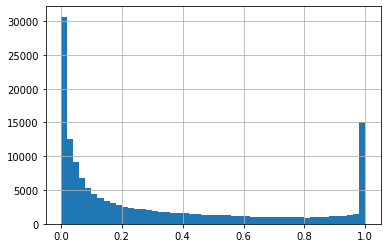



age


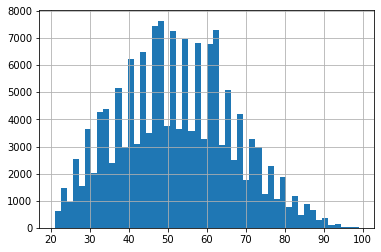



NumberOfTime30-59DaysPastDueNotWorse


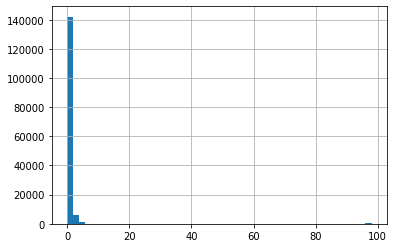



DebtRatio


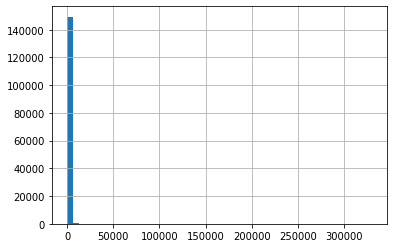



MonthlyIncome


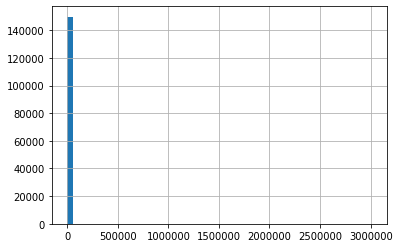



NumberOfOpenCreditLinesAndLoans


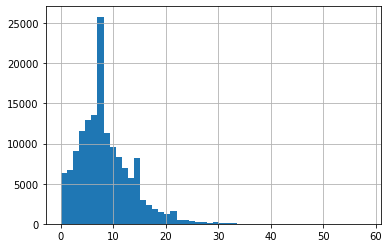



NumberOfTimes90DaysLate


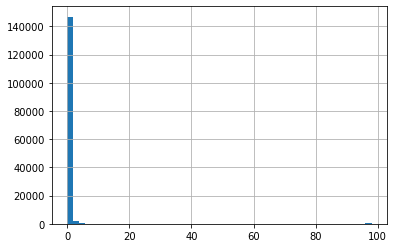



NumberRealEstateLoansOrLines


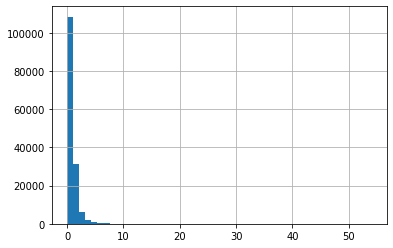



NumberOfTime60-89DaysPastDueNotWorse


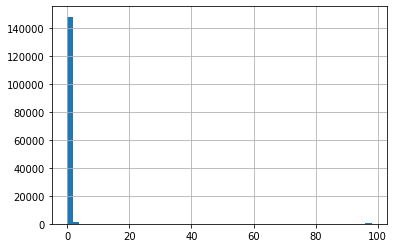



NumberOfDependents


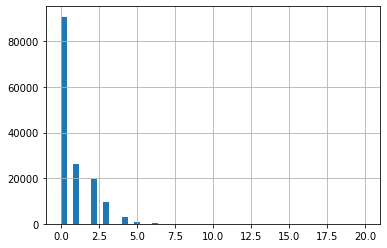

In [13]:
#Look at univariate distribution to find good binning boundaries

for c in predictors:
  print(c)
  df[c].hist(bins=50)
  plt.show()
  print('\n')

In [0]:
#function to create quantile split for each variable with given boundaries

def quantile_split(column_name, boundaries):
  left = boundaries[0]
  right = boundaries[1]
  s = pd.IntervalIndex.from_arrays(left = left, right = right)
  df[column_name+'_quantile'] = pd.cut(df[column_name],bins=s) 
  df[column_name+'_quantile_label'] = pd.Categorical(df[column_name+'_quantile']).codes
  return s


In [0]:
#function to perform binning for all variables given defined boundaries

def binning(predictors, boundary_limits):
  limits = {}
  for c in predictors:
    lim = quantile_split(c, boundary_limits[c] )
    limits.update({c: lim})
  return limits

In [0]:
# define manually chosen boundaries for variables

boundary_limits = {
    'RevolvingUtilizationOfUnsecuredLines': [[-0.001,0.05,0.2,0.4,0.7],[0.05,0.2,0.4,0.7,1]],
    'age': [[20.99,36,49,59,70],[36,49,59,70,100]],
    'NumberOfTime30-59DaysPastDueNotWorse': [[-0.001,0,1],[0,1,98]],
    'DebtRatio': [[-0.001,0.1,0.3,0.7],[0.1,0.3,0.7, 329664]],
    'MonthlyIncome': [[-0.001,3500,6000,10000,15000],[3500,6000,10000,15000,3008750]],
    'NumberOfOpenCreditLinesAndLoans': [[-0.001,3,7,10,15],[3,7,10,15,58]],
    'NumberOfTimes90DaysLate': [[-0.001,0,1],[0,1,98]],
    'NumberRealEstateLoansOrLines': [[-0.001,0,2,3,4],[0,2,3,4,54]],
    'NumberOfTime60-89DaysPastDueNotWorse': [[-0.001,0,1],[0,1,98]],
    'NumberOfDependents': [[-0.001,0,1,2,3],[0,1,2,3,20]]
}

In [0]:
binning_limits = binning(predictors, boundary_limits)

In [0]:
#define function to create weight of evidence for given binning

def WOE(column_name, target_column):
  x = df.groupby(by = column_name + '_quantile').agg({target_column:['count','sum'],column_name + '_quantile_label':['max']})
  x.reset_index(inplace=True)
  x.columns = ['Quantile','Count','Bads', 'Quantile_label']
  #x['Quantile_label'] = x['Quantile_label'].apply(lambda x: x[0]) 
  x['Goods'] = x['Count'] - x['Bads']
  x['Total_Dist'] = x['Count']/x['Count'].sum()
  x['Bads_Dist'] = x['Bads']/x['Bads'].sum()
  x['Goods_Dist'] = x['Goods']/x['Goods'].sum()
  x['Bad_Rate'] = x['Bads']/x['Count']
  x['WOE'] = np.log(x['Goods_Dist']/x['Bads_Dist'])
  x['Goods-Bads'] = x['Goods_Dist'] - x['Bads_Dist']
  x['IV_quantile'] = x['Goods-Bads']*x['WOE']
  x['Variable'] = column_name
  return x

In [58]:
binning_limits

{'DebtRatio': IntervalIndex([(-0.001, 0.1], (0.1, 0.3], (0.3, 0.7], (0.7, 329664.0]],
               closed='right',
               dtype='interval[float64]'),
 'MonthlyIncome': IntervalIndex([(-0.001, 3500.0], (3500.0, 6000.0], (6000.0, 10000.0], (10000.0, 15000.0], (15000.0, 3008750.0]],
               closed='right',
               dtype='interval[float64]'),
 'NumberOfDependents': IntervalIndex([(-0.001, 0.0], (0.0, 1.0], (1.0, 2.0], (2.0, 3.0], (3.0, 20.0]],
               closed='right',
               dtype='interval[float64]'),
 'NumberOfOpenCreditLinesAndLoans': IntervalIndex([(-0.001, 3.0], (3.0, 7.0], (7.0, 10.0], (10.0, 15.0], (15.0, 58.0]],
               closed='right',
               dtype='interval[float64]'),
 'NumberOfTime30-59DaysPastDueNotWorse': IntervalIndex([(-0.001, 0.0], (0.0, 1.0], (1.0, 98.0]],
               closed='right',
               dtype='interval[float64]'),
 'NumberOfTime60-89DaysPastDueNotWorse': IntervalIndex([(-0.001, 0.0], (0.0, 1.0], (1.0, 98.0

In [0]:
#define function to calculate information value in all variables using WOE

def IV(predictors, target_column):
  IV_df = pd.DataFrame()
  for c in predictors:
    x = WOE(column_name=c, target_column=target_column)
    IV_df = IV_df.append(x)
  IV_values = IV_df.groupby(by='Variable')['IV_quantile'].sum().reset_index()
  return IV_df, IV_values  


In [0]:
#calculate IV values and perform shortlisting of variables for credit scorecard

IV_df, IV_values = IV(predictors, target_column)

In [61]:
IV_df

,Quantile,Count,Bads,Quantile_label,Goods,Total_Dist,Bads_Dist,Goods_Dist,Bad_Rate,WOE,Goods-Bads,IV_quantile,Variable
0,"(-0.001, 0.05]",48079,850,0,47229,0.320527,0.084780,0.337413,0.017679,1.381252,0.252633,3.489500e-01,RevolvingUtilizationOfUnsecuredLines
1,"(0.05, 0.2]",33630,797,1,32833,0.224200,0.079493,0.234565,0.023699,1.082060,0.155072,1.677968e-01,RevolvingUtilizationOfUnsecuredLines
2,"(0.2, 0.4]",19844,871,2,18973,0.132293,0.086874,0.135547,0.043892,0.444855,0.048672,2.165221e-02,RevolvingUtilizationOfUnsecuredLines
3,"(0.4, 0.7]",18499,1554,3,16945,0.123327,0.154997,0.121058,0.084005,-0.247134,-0.033939,8.387448e-03,RevolvingUtilizationOfUnsecuredLines
4,"(0.7, 1.0]",29948,5954,4,23994,0.199653,0.593856,0.171418,0.198811,-1.242534,-0.422438,5.248943e-01,RevolvingUtilizationOfUnsecuredLines
0,"(20.99, 36.0]",23864,2628,0,21236,0.159093,0.262118,0.151714,0.110124,-0.546800,-0.110405,6.036926e-02,age
1,"(36.0, 49.0]",42516,3620,1,38896,0.283440,0.361061,0.277880,0.085144,-0.261858,-0.083181,2.178159e-02,age
2,"(49.0, 59.0]",35315,2279,2,33036,0.235433,0.227309,0.236015,0.064533,0.037586,0.008706,3.272350e-04,age
3,"(59.0, 70.0]",30682,1102,3,29580,0.204547,0.109914,0.211325,0.035917,0.653697,0.101411,6.629187e-02,age
4,"(70.0, 100.0]",17623,397,4,17226,0.117487,0.039597,0.123066,0.022527,1.133964,0.083469,9.465045e-02,age


In [22]:
IV_values.sort_values(by='IV_quantile', ascending=False)

,Variable,IV_quantile
8,RevolvingUtilizationOfUnsecuredLines,1.071681
6,NumberOfTimes90DaysLate,0.873322
4,NumberOfTime30-59DaysPastDueNotWorse,0.740481
5,NumberOfTime60-89DaysPastDueNotWorse,0.599026
9,age,0.243420
7,NumberRealEstateLoansOrLines,0.064012
3,NumberOfOpenCreditLinesAndLoans,0.063913
1,MonthlyIncome,0.056637
2,NumberOfDependents,0.034446
0,DebtRatio,0.012415


In [0]:
#use variables with IV > 0.1 in the model

retain_predictors = list(IV_values.loc[IV_values['IV_quantile'] > 0.1]['Variable'].unique())

In [24]:
retain_predictors

['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [25]:
df1 = df.copy(deep=True)
for col in retain_predictors:
  IV_df1 = IV_df.loc[IV_df['Variable']==col]
  IV_df1['WOE_' + col] = IV_df1['WOE']
  df1 = df1.merge(IV_df1[['Quantile_label', 'WOE_'+ col]], left_on =  col+'_quantile_label', right_on = 'Quantile_label', how='left')
  #df1.drop('Quantile_label', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
#develop a logistic model using 5 variables shortlisted above

WOE_variables = []
for c in retain_predictors:
  WOE_variables.append('WOE_' + c)

X = df1[WOE_variables]
y = df1[target_column]
clf = LogisticRegression(random_state=234).fit(X, y)

In [27]:
clf.coef_

array([[-0.52995762, -0.38550983, -0.53358877, -0.64232224, -0.45193821]])

In [0]:
retain_predictors 

['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [0]:
#define function to calculate individual and overall score

def credit_scoring(retain_predictors, betas, pdo = 20, base_score = 600, base_odds = 50):
  n = len(retain_predictors)
  factor = pdo/np.log(2)
  offset = base_score - factor*np.log(base_odds)
  #print(offset)
  individual_scores = []
  for i in range(len(retain_predictors)):
    individual_scores.append(retain_predictors[i] + '_score')
    df1[retain_predictors[i] + '_score'] = -1 * (df1['WOE_' + retain_predictors[i]] * betas[0][i] + clf.intercept_[0]/n)*factor + offset/n
  df1['credit_score'] = df1[individual_scores].sum(axis=1)  

In [0]:
credit_scoring(retain_predictors = retain_predictors, betas = clf.coef_)

In [31]:
df1.iloc[7]

SeriousDlqin2yrs                                                      0
RevolvingUtilizationOfUnsecuredLines                           0.754464
age                                                                  39
NumberOfTime30-59DaysPastDueNotWorse                                  0
DebtRatio                                                       0.20994
MonthlyIncome                                                      3500
NumberOfOpenCreditLinesAndLoans                                       8
NumberOfTimes90DaysLate                                               0
NumberRealEstateLoansOrLines                                          0
NumberOfTime60-89DaysPastDueNotWorse                                  0
NumberOfDependents                                                    0
RevolvingUtilizationOfUnsecuredLines_quantile                (0.7, 1.0]
RevolvingUtilizationOfUnsecuredLines_quantile_label                   4
age_quantile                                               (36.0

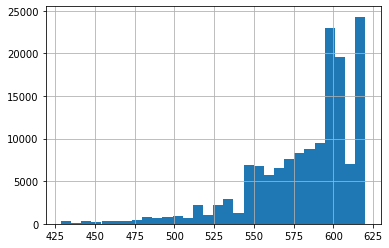

In [33]:
df1.credit_score.hist(bins = 30)

In [0]:
df1['Score_decile'] = pd.qcut(df1['credit_score'], q = 10)
df2 = df1.groupby(by = 'Score_decile').agg({target_column:['mean']})

In [77]:
df2

,SeriousDlqin2yrs
,mean
Score_decile,
"(428.529, 538.246]",0.354303
"(538.246, 557.153]",0.104753
"(557.153, 571.696]",0.065090
"(571.696, 583.635]",0.044368
"(583.635, 592.615]",0.027068
"(592.615, 598.16]",0.018210
"(598.16, 601.876]",0.012546
"(601.876, 608.27]",0.010619


In [0]:
#Export model details into a json file 

k = 0
beta_coeff = {'intercept':clf.intercept_[0]}
for col in retain_predictors:
  beta_coeff.update({col: clf.coef_[0][k]})
  k = k+1

model_coefficients = {'Coefficients': beta_coeff}  
with open('model_scorecard.json', 'w') as fp:
    json.dump(model_coefficients, fp, indent = 5)
IV_df.reset_index(drop=True).to_json('Binning_details.json')    

In [0]:
#Read model and binning details

with open("model_scorecard.json", "r") as read_file:
    model = json.load(read_file)

binning_df = pd.read_json('Binning_details.json')    
binning_df['left'] = binning_df['Quantile'].apply(lambda x: x['left'])
binning_df['right'] = binning_df['Quantile'].apply(lambda x: x['right'])  
WOE_df = binning_df[['Variable','left','right','WOE']]
WOE_df.to_json('WOE_details.json') 
WOE_df = pd.read_json('WOE_details.json')   

In [127]:
WOE_df

,Variable,left,right,WOE
0,RevolvingUtilizationOfUnsecuredLines,-0.001,0.05,1.381252
1,RevolvingUtilizationOfUnsecuredLines,0.050,0.20,1.082060
2,RevolvingUtilizationOfUnsecuredLines,0.200,0.40,0.444855
3,RevolvingUtilizationOfUnsecuredLines,0.400,0.70,-0.247134
4,RevolvingUtilizationOfUnsecuredLines,0.700,1.00,-1.242534
5,age,20.990,36.00,-0.546800
6,age,36.000,49.00,-0.261858
7,age,49.000,59.00,0.037586
8,age,59.000,70.00,0.653697
9,age,70.000,100.00,1.133964


In [0]:
#read test data an score it 

link = 'https://drive.google.com/open?id=1D-hyNIfnibYokvlDA-dyHc-z3b_WwoJx'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('test_data.csv')

In [0]:
test_df = pd.read_csv('test_data.csv')

In [169]:
test_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [0]:
def score_application(row, model):  
  credit_score = 0
  for variable in model['Coefficients'].keys():
    if variable != 'intercept':
      x = WOE_df.loc[WOE_df['Variable'] == variable]
      x['App_value'] = row[variable]      
      x['Flag'] = 0
      x.loc[(x['App_value'] > x['left']) & (x['App_value'] <= x['right']), 'Flag'] = 1 
      x['woe'] = x['Flag'] * x['WOE']
      woe = x['woe'].sum()
      score = -1 * (woe * model['Coefficients'][variable] + model['Coefficients']['intercept']/n)*factor + offset/n
      credit_score = credit_score + score
      row[variable+'_score'] = np.round(score)
  row['credit_score'] = np.round(credit_score)
  return row  

In [0]:
n = len(model['Coefficients'].keys()) - 1
pdo = 20
base_score = 600
base_odds = 50
factor = pdo/np.log(2)
offset = base_score - factor*np.log(base_odds)
test_df1 = test_df.sample(1000).apply(lambda x : score_application(x, model), axis = 1)

In [180]:
test_df1.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberOfTime30-59DaysPastDueNotWorse_score,NumberOfTime60-89DaysPastDueNotWorse_score,NumberOfTimes90DaysLate_score,RevolvingUtilizationOfUnsecuredLines_score,age_score,credit_score
23252,23253.0,NaN,0.045933,47.0,0.0,0.273340,8600.0,5.0,0.0,1.0,0.0,2.0,121.0,116.0,118.0,138.0,109.0,602.0
3476,3477.0,NaN,0.152063,35.0,0.0,0.257350,2210.0,8.0,0.0,0.0,0.0,0.0,121.0,116.0,118.0,132.0,105.0,593.0
37820,37821.0,NaN,0.504062,41.0,2.0,0.241701,7500.0,6.0,0.0,1.0,0.0,0.0,83.0,116.0,118.0,108.0,109.0,534.0
42287,42288.0,NaN,1.000000,80.0,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,NaN,121.0,116.0,118.0,89.0,127.0,571.0
23176,23177.0,NaN,0.043979,90.0,0.0,0.131269,8333.0,5.0,0.0,1.0,0.0,0.0,121.0,116.0,118.0,138.0,127.0,620.0
